# Smart AirBnB booking in Berlin 
The following notebook will address some key questions about Berlin AirBnB listings data.

Article on my website: [Smart AirBnB booking in Berlin](https://github.com/ChristianHallerX/DataScienceProjects/blob/master/AirBNB_Berlin.ipynb)

## Steps
1. **Download Data**
2. **Explore Data**
3. **Data Cleaning**
4. **Analyze/Visualize**
    1. How are the prices distributed?
    2. Breakdown of listings by room type.  
    3. What is the median price of a listing by district and room type. 
    4. What is the average difference in a listing price between superhost and non-superhost status for each room type and district?
5. **Regression Model**
    5. Which website options influence the price? (Regression problem: idenfying predictor variables). 

### Import libraries.

In [1]:
import os
import wget
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import re
import csv
import unidecode
import wptools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

%matplotlib inline 

#set default style
sns.set_style("whitegrid", {'font.sans-serif': 'DejaVu Sans'})

## 1. Download Data

The Berlin data were obtained from Inside AirBnB: http://insideairbnb.com/get-the-data.html. **Download Date**: 17th September 2020. **Sraping Date**: 30th August 2020.

Inside AirBnB serves a map of all the data set samples: http://insideairbnb.com/berlin/

In [2]:
wget.download("http://data.insideairbnb.com/germany/be/berlin/2020-08-30/data/listings.csv.gz", out=f'{os.getcwd()}\\Data\\AirBNB_Berlin')
wget.download("http://data.insideairbnb.com/germany/be/berlin/2020-08-30/data/calendar.csv.gz",out=f'{os.getcwd()}\\Data\\AirBNB_Berlin')

'C:\\Users\\ChristianV700\\Documents\\GitHub\\DataScienceProjects\\Data\\AirBNB_Berlin/calendar.csv.gz'

The listings csv contains all active accommodations for Berlin.

In [3]:
import gzip

with gzip.open('Data/AirBNB_Berlin/listings.csv.gz') as f:
    listings = pd.read_csv(f)

listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1944,https://www.airbnb.com/rooms/1944,20200830153825,2020-08-31,cafeheaven Pberg/Mitte,"Private, bright and friendly room. You'd be sh...",near all the trendy cafés and flea markets and...,https://a0.muscache.com/pictures/107924758/1f4...,2164,https://www.airbnb.com/users/show/2164,...,9.0,9.0,8.0,NaN,f,2,0,2,0,0.21
1,3176,https://www.airbnb.com/rooms/3176,20200830153825,2020-08-31,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,The neighbourhood is famous for its variety of...,https://a0.muscache.com/pictures/243355/84afcf...,3718,https://www.airbnb.com/users/show/3718,...,9.0,10.0,9.0,NaN,f,1,1,0,0,1.07
2,3309,https://www.airbnb.com/rooms/3309,20200830153825,2020-09-01,BerlinSpot Schöneberg near KaDeWe,First of all:<br />I prefer short-notice booki...,"My flat is in the middle of West-Berlin, direc...",https://a0.muscache.com/pictures/29054294/b1fa...,4108,https://www.airbnb.com/users/show/4108,...,10.0,9.0,9.0,NaN,f,1,0,1,0,0.31
3,7071,https://www.airbnb.com/rooms/7071,20200830153825,2020-08-31,BrightRoom with sunny greenview!,Cozy and large room in the beautiful district ...,"Great neighborhood with plenty of Cafés, Baker...",https://a0.muscache.com/pictures/21278/32a1622...,17391,https://www.airbnb.com/users/show/17391,...,10.0,10.0,9.0,NaN,t,1,0,1,0,2.18
4,9991,https://www.airbnb.com/rooms/9991,20200830153825,2020-08-31,Geourgeous flat - outstanding views,4 bedroom with very large windows and outstand...,Prenzlauer Berg is an amazing neighbourhood wh...,https://a0.muscache.com/pictures/42799131/59c8...,33852,https://www.airbnb.com/users/show/33852,...,10.0,10.0,10.0,03/Z/RA/003410-18,f,1,1,0,0,0.13


The calendar csv contains all the posted dates and prices listed for each location.

In [4]:
with gzip.open('Data/AirBNB_Berlin/calendar.csv.gz') as f:
    calendar = pd.read_csv(f)

calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,186851,2020-09-01,f,$33.00,$33.00,62.0,300.0
1,1944,2020-08-31,f,$20.00,$20.00,60.0,120.0
2,1944,2020-09-01,f,$20.00,$20.00,60.0,120.0
3,1944,2020-09-02,f,$20.00,$20.00,60.0,120.0
4,1944,2020-09-03,f,$20.00,$20.00,60.0,120.0


## 2. Explore Data

In [5]:
#get general info
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20432 entries, 0 to 20431
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20432 non-null  int64  
 1   listing_url                                   20432 non-null  object 
 2   scrape_id                                     20432 non-null  int64  
 3   last_scraped                                  20432 non-null  object 
 4   name                                          20400 non-null  object 
 5   description                                   19918 non-null  object 
 6   neighborhood_overview                         11186 non-null  object 
 7   picture_url                                   20432 non-null  object 
 8   host_id                                       20432 non-null  int64  
 9   host_url                                      20432 non-null 

In [6]:
#see how many room types
listings.room_type.value_counts()

Entire home/apt    11047
Private room        8870
Shared room          279
Hotel room           236
Name: room_type, dtype: int64

In [7]:
#check for any missing values
listings.room_type.isna().sum()

0

In [8]:
#see the accomodates numbers
listings.accommodates.value_counts()

2     10739
4      3055
1      2350
3      2243
6       806
5       710
8       168
7       150
10       66
9        44
12       33
16       22
11       17
14       13
15        7
13        7
0         2
Name: accommodates, dtype: int64

In [9]:
#check for any missing values
listings.accommodates.isna().sum()

0

## Bathrooms

In [10]:
#see bathroom count. Somewhat little consistency. Note that all of the non-numeric values are half baths (toilet only, no shower)!
listings.bathrooms_text.value_counts()

1 bath               11275
1 shared bath         5340
1 private bath         895
2 baths                866
1.5 baths              821
1.5 shared baths       533
2 shared baths         289
2.5 baths              111
2.5 shared baths        50
0 baths                 45
3 baths                 44
Half-bath               40
0 shared baths          29
Shared half-bath        18
4 baths                 10
7 baths                  9
3 shared baths           8
3.5 baths                6
5 shared baths           4
4 shared baths           4
4.5 baths                3
8.5 shared baths         3
Private half-bath        2
8 baths                  1
6 baths                  1
7.5 baths                1
5 baths                  1
Name: bathrooms_text, dtype: int64

In [11]:
#check for any missing values
listings.bathrooms_text.isna().sum()

#23 locations are missing bathrooms? 

23

In [12]:
#Explore listings with missing bathroom value 
listings[listings.bathrooms_text.isna()][['bathrooms_text','beds', 'bedrooms', 'listing_url', 'property_type']].head(10)

,bathrooms_text,beds,bedrooms,listing_url,property_type
35,NaN,2.0,2.0,https://www.airbnb.com/rooms/52570,Entire apartment
88,NaN,1.0,1.0,https://www.airbnb.com/rooms/162111,Private room in apartment
118,NaN,1.0,1.0,https://www.airbnb.com/rooms/186717,Entire apartment
123,NaN,1.0,1.0,https://www.airbnb.com/rooms/189596,Entire apartment
192,NaN,2.0,1.0,https://www.airbnb.com/rooms/246007,Entire apartment
218,NaN,3.0,1.0,https://www.airbnb.com/rooms/254551,Entire apartment
271,NaN,1.0,1.0,https://www.airbnb.com/rooms/302167,Entire apartment
388,NaN,1.0,1.0,https://www.airbnb.com/rooms/512476,Entire apartment
412,NaN,3.0,1.0,https://www.airbnb.com/rooms/555352,Camper/RV
416,NaN,1.0,1.0,https://www.airbnb.com/rooms/563505,Entire apartment


In [13]:
#What kind of properties explicitly contain zero bathroom?
listings.loc[listings['bathrooms_text']=='0 baths'][['bathrooms_text','beds', 'bedrooms', 'listing_url', 'property_type']]

,bathrooms_text,beds,bedrooms,listing_url,property_type
219,0 baths,3.0,1.0,https://www.airbnb.com/rooms/254559,Entire apartment
226,0 baths,3.0,NaN,https://www.airbnb.com/rooms/255209,Entire apartment
242,0 baths,1.0,1.0,https://www.airbnb.com/rooms/265389,Private room in hostel
531,0 baths,2.0,1.0,https://www.airbnb.com/rooms/726236,Entire apartment
681,0 baths,1.0,1.0,https://www.airbnb.com/rooms/926497,Private room in apartment
1208,0 baths,0.0,NaN,https://www.airbnb.com/rooms/2070349,Entire apartment
1950,0 baths,1.0,NaN,https://www.airbnb.com/rooms/4018296,Entire loft
2299,0 baths,1.0,NaN,https://www.airbnb.com/rooms/4816644,Entire apartment
2659,0 baths,1.0,1.0,https://www.airbnb.com/rooms/5875924,Private room in apartment
2826,0 baths,1.0,1.0,https://www.airbnb.com/rooms/6322584,Private room in apartment


## Bedrooms/Beds

In [14]:
#see bedroom count - There are no samples with explicitly 0 bedrooms!
listings.bedrooms.value_counts()

1.0     14997
2.0      2823
3.0       709
4.0       150
5.0        37
6.0        16
7.0         4
8.0         3
10.0        2
12.0        1
Name: bedrooms, dtype: int64

In [15]:
#but there are plenty of missing values
listings.bedrooms.isna().sum()

1690

In [16]:
#see bed counts - There are no samples with explicitly 0 beds!
listings.beds.value_counts()

1.0     11849
2.0      4820
3.0      1380
4.0       758
0.0       690
5.0       277
6.0       224
7.0        78
8.0        54
10.0       22
9.0        17
12.0        8
11.0        7
16.0        5
15.0        3
14.0        2
17.0        2
Name: beds, dtype: int64

In [17]:
#check for any missing values
listings.beds.isna().sum()

#236 that do not have any information about beds
#might be interesting to look into these to see if this is just an error or if there are actually no beds...

236

In [18]:
#exlpore entries with missing bed value
# if they have a bedroom listed then they surely have a bed... what about the entries with missing bed and missing bedroom value?

listings[listings.beds.isna() &listings.bedrooms.isna() ][['beds','room_type','listing_url', 'bedrooms']]

,beds,room_type,listing_url,bedrooms
6685,NaN,Entire home/apt,https://www.airbnb.com/rooms/15933853,NaN
12320,NaN,Entire home/apt,https://www.airbnb.com/rooms/28132083,NaN
16534,NaN,Private room,https://www.airbnb.com/rooms/38802547,NaN
16542,NaN,Private room,https://www.airbnb.com/rooms/38813440,NaN
16903,NaN,Private room,https://www.airbnb.com/rooms/39527464,NaN
17069,NaN,Entire home/apt,https://www.airbnb.com/rooms/39839444,NaN
17339,NaN,Entire home/apt,https://www.airbnb.com/rooms/40335581,NaN
17474,NaN,Entire home/apt,https://www.airbnb.com/rooms/40546946,NaN
17487,NaN,Entire home/apt,https://www.airbnb.com/rooms/40563469,NaN
17848,NaN,Private room,https://www.airbnb.com/rooms/41044666,NaN


## Minimum Nights

In [19]:
#check for missing values
listings.minimum_nights.isna().sum()

0

In [20]:
#see property type count
listings.property_type.value_counts()
#there are some interesting listing types! 

Entire apartment             9652
Private room in apartment    7951
Entire loft                   358
Entire condominium            305
Entire serviced apartment     302
                             ... 
Castle                          1
Shared room in cabin            1
Shared room in townhouse        1
Private room in houseboat       1
Private room in cottage         1
Name: property_type, Length: 66, dtype: int64

In [21]:
#check for any missing values 
listings.property_type.isna().sum()

0

In [22]:
#how many unique listings at the time of scraping?
listings.id.nunique()

20432

In [23]:
#explore neighbourhoods_cleansed
listings.neighbourhood_cleansed.value_counts()

Frankfurter Allee Süd FK              1159
Alexanderplatz                        1117
Tempelhofer Vorstadt                  1027
Reuterstraße                           847
Brunnenstr. Süd                        779
                                      ... 
Buckow Nord                              3
Neu-Hohenschönhausen Süd                 3
Malchow, Wartenberg und Falkenberg       2
Neu-Hohenschönhausen Nord                2
Marzahn-Nord                             1
Name: neighbourhood_cleansed, Length: 137, dtype: int64

## 3. Data Cleaning

A. Perform some tidying on the listings df - to be used for data visualization. 
 1. Remove some random columns that will not be used in this analysis and remove columns with All NAs.
 2. Create district column using the cleansed neighbourhoods
     -> Use the wptools API to get the neighbourhoods by districts table on the Wiki Page. 
 3. Clean up odd bedroom numbers and infer any missing.  
 4. Clean up odd bathrooms and infer any missing.
 5. Infer missing beds. 
 6. Clean up price. 

B. Join the calendar df with the listings df to get the price of each listing at a certain date.
    Note***: Will still retain the original listings df for data visualization purposes. 
 1. Remove some columns not interested in
 2. Create day of the week using the date in cal df. 
 3. Select only unique days (Monday - Friday for each listing_id x month X year)
 4. Clean up adjusted price.

### A. Perform some tidying of the listings df.

### Fix 'Bedrooms'

In [24]:
#remove columns that have all missing values 
listings.columns[listings.isnull().mean()==1].tolist()

['bathrooms', 'calendar_updated']

In [25]:
#remove columns that have all missing values 
listings = listings.drop(listings.columns[listings.isnull().mean()==1].tolist(), axis=1)

In [26]:
#fill in the bedrooms using information from other columns -> 'name' and 'description' indicate that NaN in 'bedrooms' is often the case studio apartments
listings[listings.bedrooms.isna()][['bedrooms','beds','name', 'description', 'room_type']]

,bedrooms,beds,name,description,room_type
5,NaN,1.0,Apartment in Prenzlauer Berg,The apartment is located on the upper second f...,Entire home/apt
7,NaN,0.0,Beautiful Kreuzberg studio/fast WiFi,- beautiful studio apt in downtown Berlin - cl...,Entire home/apt
16,NaN,1.0,Beautiful apartment in Prenzlauer Berg,The apartment is located on the upper ground f...,Entire home/apt
47,NaN,2.0,Quiet studio in Prenzlauer Berg near Mauerpark,COVID CLEANING PROTOCOL<br />In order to help ...,Entire home/apt
79,NaN,1.0,1-room apartment in Kreuzkölln/WIFI,Best location on the canal/Kottbusser Damm. Th...,Entire home/apt
...,...,...,...,...,...
20402,NaN,4.0,In der Nähe der U-Bahnstation finden 7 Personen,"Das Apartment verfügt über einen Essbereich, e...",Entire home/apt
20409,NaN,1.0,Cozy Quiet Apartment in the center of Berlin,My apartment is super central yet super quiet....,Entire home/apt
20421,NaN,0.0,Sunny duplex apt. on northern Friedrichstrasse,Very comfortable 60 square meters duplex apart...,Entire home/apt
20423,NaN,1.0,Apartment near Alexanderplatz in Friedrichshain,Genieße Deinen nächsten Berlin-Aufenthalt in u...,Entire home/apt


### Studios are a tough decision what to fill in. Zero or One? Many hosts simply leave it blank when listing.
I will call a studio a 0-bedroom location to have it as a separate category distinguishable from larger apartments.

In [27]:
#assign 0 bedrooms to NAN
listings['bedrooms'] = np.where(listings['bedrooms'].isna(), 0, listings['bedrooms'])
#check to make sure it worked
listings.bedrooms.isna().sum()

0

The 'Accommodates' feature can be used to fill in 'Beds' where missing.

In [28]:
#now look at beds
listings[listings.beds.isna()][['beds','description', 'listing_url', 'bathrooms_text', 'bedrooms', 'accommodates']].head(20)

,beds,description,listing_url,bathrooms_text,bedrooms,accommodates
449,NaN,<b>The space</b><br />Very nice 4-room apartme...,https://www.airbnb.com/rooms/609459,NaN,1.0,2
507,NaN,<b>The space</b><br />Wohnart: Wohnung <br />...,https://www.airbnb.com/rooms/694373,NaN,1.0,2
1034,NaN,<b>The space</b><br />schöne wohnung,https://www.airbnb.com/rooms/1660112,NaN,1.0,1
1544,NaN,A quiet location in the heart of Friedrichshai...,https://www.airbnb.com/rooms/3023254,NaN,1.0,2
6685,NaN,Meine Unterkunft ist in der Nähe von Neukölln ...,https://www.airbnb.com/rooms/15933853,1 bath,0.0,1
6784,NaN,"I'm renting my cousy room in shared apartment,...",https://www.airbnb.com/rooms/16144309,1.5 baths,1.0,2
9072,NaN,Zentral und ruhig gelegen im beliebten Kiez Ne...,https://www.airbnb.com/rooms/20522634,1 bath,1.0,2
9105,NaN,I'm subletting my lovely room in the Berlin di...,https://www.airbnb.com/rooms/20589409,1 shared bath,1.0,2
9113,NaN,"Big, bright and airy room in a comfortable and...",https://www.airbnb.com/rooms/20598100,1 shared bath,1.0,2
11927,NaN,<b>The space</b><br />We are a family owned an...,https://www.airbnb.com/rooms/27011856,1 private bath,1.0,2


In [29]:
listings[listings.beds.isna()][['description', 'listing_url', 'bathrooms_text', 'bedrooms', 'accommodates']].accommodates.value_counts()

2    144
1     58
6     16
4     11
3      5
0      2
Name: accommodates, dtype: int64

### Fix beds

In [30]:
#if listing accomodates 1 there must be only 1 bed
listings.loc[(listings['accommodates'] == 1), 'beds'] = 1

#if there is 1 bedroom and accomodates 2 there must be at least 1 double bed
listings.loc[((listings['accommodates'] == 2) & (listings['bedrooms'] == 1)) , 'beds'] = 1

#if there are 2 bedrooms and accomodates 4 there must be at least 2 beds -> two double beds
listings.loc[((listings['accommodates'] == 4) & (listings['bedrooms'] == 2)) , 'beds'] = 2

#if there are 3 bedrooms and accomodates 5 there must be at least 3 beds
accom = [5,6]
listings.loc[((listings['accommodates'].isin(accom)) & (listings['bedrooms'] == 3)) , 'beds'] = 3

In [31]:
# after that tidying up, how many samples are sill left with NA?
listings.beds.isna().sum()

47

In [32]:
#assign 1 bed to these ones missing 
listings['beds'] = np.where(listings['beds'].isna(), 1, listings['beds'])
#check to make sure it worked
listings.beds.isna().sum()

0

### Fix 'Bathrooms'

In [33]:
listings[['beds','description', 'listing_url', 'bathrooms_text', 'bedrooms', 'accommodates']].head(40)

,beds,description,listing_url,bathrooms_text,bedrooms,accommodates
0,1.0,"Private, bright and friendly room. You'd be sh...",https://www.airbnb.com/rooms/1944,1 shared bath,1.0,1
1,2.0,This beautiful first floor apartment is situa...,https://www.airbnb.com/rooms/3176,1 bath,1.0,4
2,1.0,First of all:<br />I prefer short-notice booki...,https://www.airbnb.com/rooms/3309,1 shared bath,1.0,1
3,1.0,Cozy and large room in the beautiful district ...,https://www.airbnb.com/rooms/7071,1 shared bath,1.0,2
4,7.0,4 bedroom with very large windows and outstand...,https://www.airbnb.com/rooms/9991,2.5 baths,4.0,7
5,1.0,The apartment is located on the upper second f...,https://www.airbnb.com/rooms/14325,1 bath,0.0,1
6,3.0,Light and sunny 2-Room-turn of the century-fla...,https://www.airbnb.com/rooms/16644,1 bath,1.0,5
7,0.0,- beautiful studio apt in downtown Berlin - cl...,https://www.airbnb.com/rooms/17904,1 bath,0.0,2
8,2.0,Bright and sunny condo with two balconies in a...,https://www.airbnb.com/rooms/20858,1 bath,2.0,4
9,2.0,Light and sunny 1-Room-turn of the century-fla...,https://www.airbnb.com/rooms/21869,1 bath,1.0,4


In [34]:
#deal with missing bathrooms (there should be at least 1 bathroom)
listings[listings.bathrooms_text.isna()][['bathrooms_text','listing_url']]

,bathrooms_text,listing_url
35,NaN,https://www.airbnb.com/rooms/52570
88,NaN,https://www.airbnb.com/rooms/162111
118,NaN,https://www.airbnb.com/rooms/186717
123,NaN,https://www.airbnb.com/rooms/189596
192,NaN,https://www.airbnb.com/rooms/246007
218,NaN,https://www.airbnb.com/rooms/254551
271,NaN,https://www.airbnb.com/rooms/302167
388,NaN,https://www.airbnb.com/rooms/512476
412,NaN,https://www.airbnb.com/rooms/555352
416,NaN,https://www.airbnb.com/rooms/563505


In [35]:
#Assumption: assign 1 bathroom (temporary as string to work with regex strings, cast to floats later on)
listings.loc[listings['bathrooms_text'].isna(), 'bathrooms_text'] = '1'

In [36]:
#make sure it worked
listings.bathrooms_text.isna().sum()

0

In [37]:
listings['bathrooms_text'].head(20)

0     1 shared bath
1            1 bath
2     1 shared bath
3     1 shared bath
4         2.5 baths
5            1 bath
6            1 bath
7            1 bath
8            1 bath
9            1 bath
10           1 bath
11           1 bath
12           1 bath
13           1 bath
14        2.5 baths
15        2.5 baths
16           1 bath
17           1 bath
18           1 bath
19    1 shared bath
Name: bathrooms_text, dtype: object

In [38]:
len(listings['bathrooms_text'])

20432

In [39]:
#bathrooms_text is a string and not as useful as a simple float or integer. Extract the numerical values
import re
bath_numbers = []
separator = '.'
for row in listings['bathrooms_text'].values:
    try:
        str(row)
        shards = re.findall(r'[0-9]+', row)
        if len(shards)>1:
            bath_numbers.append(float(separator.join(shards)))
        elif len(shards)==1:
            bath_numbers.append(float(shards[0]))
        elif len(shards)==0:
            bath_numbers.append(0.5)
        else:
            print(shards)
    except Exception as e:
        print(e)

#check lenght again
len(bath_numbers)

20432

In [40]:
# tie the numerical values back into the listings
listings['bathrooms_numerical'] = bath_numbers

### Join the Wikipedia table (neighborhoods) with the listings (districts) 

The listings df already contains the districts. Add the neighborhoods to it!

Wiki Source Page: Table 2 of https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins

Plug in address in https://wikitable2csv.ggor.de/ and download CSV to 'Data/AirBNB_Berlin/table-2.csv'

In [41]:
# the join can be accomplished on the 'district' feature
nbhds = pd.read_csv('Data/AirBNB_Berlin/table-2.csv', header=0, names=['ID', 'neighborhood', 'district', 'area', 'pop', 'pop_density'], encoding="utf-8")
nbhds

,ID,neighborhood,district,area,pop,pop_density
0,101,Mitte,Mitte,"10,70",102.465,9576
1,102,Moabit,Mitte,"7,72",80.495,10.427
2,103,Hansaviertel,Mitte,"0,53",5.926,11.181
3,104,Tiergarten,Mitte,"5,17",14.881,2878
4,105,Wedding,Mitte,"9,23",86.806,9405
...,...,...,...,...,...,...
91,1207,Waidmannslust,Reinickendorf,"2,30",10.973,4771
92,1208,Lübars,Reinickendorf,"5,00",5.203,1041
93,1209,Wittenau,Reinickendorf,"5,90",24.656,4179
94,1210,Märkisches Viertel,Reinickendorf,"3,20",40.379,12.618


### Adjust some district names in the 'listings' for joining

In [42]:
# see the correct naming from wiki
sorted(nbhds.district.unique())

['Charlottenburg-Wilmersdorf',
 'Friedrichshain-Kreuzberg',
 'Lichtenberg',
 'Marzahn-Hellersdorf',
 'Mitte',
 'Neukölln',
 'Pankow',
 'Reinickendorf',
 'Spandau',
 'Steglitz-Zehlendorf',
 'Tempelhof-Schöneberg',
 'Treptow-Köpenick']

In [43]:
# listings before
sorted(listings.neighbourhood_group_cleansed.unique())

['Charlottenburg-Wilm.',
 'Friedrichshain-Kreuzberg',
 'Lichtenberg',
 'Marzahn - Hellersdorf',
 'Mitte',
 'Neukölln',
 'Pankow',
 'Reinickendorf',
 'Spandau',
 'Steglitz - Zehlendorf',
 'Tempelhof - Schöneberg',
 'Treptow - Köpenick']

In [44]:
# rename some neighborhoods - listings after
listings['neighbourhood_group_cleansed'] = np.where(listings['neighbourhood_group_cleansed'] == 'Charlottenburg-Wilm.','Charlottenburg-Wilmersdorf',  listings['neighbourhood_group_cleansed'])
listings['neighbourhood_group_cleansed'] = np.where(listings['neighbourhood_group_cleansed'] == 'Tempelhof - Schöneberg','Tempelhof-Schöneberg',  listings['neighbourhood_group_cleansed'])
listings['neighbourhood_group_cleansed'] = np.where(listings['neighbourhood_group_cleansed'] == 'Steglitz - Zehlendorf','Steglitz-Zehlendorf',  listings['neighbourhood_group_cleansed'])
listings['neighbourhood_group_cleansed'] = np.where(listings['neighbourhood_group_cleansed'] == 'Marzahn - Hellersdorf','Marzahn-Hellersdorf',  listings['neighbourhood_group_cleansed'])
listings['neighbourhood_group_cleansed'] = np.where(listings['neighbourhood_group_cleansed'] == 'Treptow - Köpenick','Treptow-Köpenick',  listings['neighbourhood_group_cleansed'])
sorted(listings.neighbourhood_group_cleansed.unique())

['Charlottenburg-Wilmersdorf',
 'Friedrichshain-Kreuzberg',
 'Lichtenberg',
 'Marzahn-Hellersdorf',
 'Mitte',
 'Neukölln',
 'Pankow',
 'Reinickendorf',
 'Spandau',
 'Steglitz-Zehlendorf',
 'Tempelhof-Schöneberg',
 'Treptow-Köpenick']

In [45]:
# rename listings column 'neighbourhood_group_cleansed' feature to match nbhd
listings.rename(columns={"neighbourhood_group_cleansed": "district"}, inplace=True)

In [46]:
#do a join on the districts to add the wikipedia neighbourhoods
#list2 = listings.join(nbhds, on="district")
list2 = pd.merge(listings, nbhds, on='district', how='inner')

# list2 got 5 extra features! (ID, neighborhood, area, pop, pop_density)
list2.shape,listings.shape

((136034, 78), (20432, 73))

### Price feature processing

In [47]:
#Clean up the price column. 
list2.price.value_counts()

$50.00     6690
$40.00     5930
$30.00     5819
$35.00     5320
$45.00     4882
           ... 
$66.43        2
$32.86        2
$30.71        2
$75.86        2
$558.00       2
Name: price, Length: 615, dtype: int64

In [48]:
#strip the $ sign and the thousands-separator comma from the price
list2.price = list2.price.str.replace('$', "")
list2.price = list2.price.str.replace(',', "")
list2.price.value_counts()

50.00     6690
40.00     5930
30.00     5819
35.00     5320
45.00     4882
          ... 
63.57        2
207.14       2
363.00       2
118.57       2
78.29        2
Name: price, Length: 615, dtype: int64

In [49]:
#filter listings to remove price that is listed as 0 or as null
list3 = list2.dropna(subset=['price'], axis=0)
list3.price.isnull().sum()

0

In [50]:
#convert to a float
list3['price'] = list3['price'].astype(float)

# funny enough there are some 0 prices?
list3.price.describe()

count    136034.000000
mean         70.626410
std         125.542532
min           0.000000
25%          35.000000
50%          51.000000
75%          80.000000
max        8000.000000
Name: price, dtype: float64

### B. Join the calendar df (prices) with the listings df (locations)

In [51]:
calendar

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,186851,2020-09-01,f,$33.00,$33.00,62.0,300.0
1,1944,2020-08-31,f,$20.00,$20.00,60.0,120.0
2,1944,2020-09-01,f,$20.00,$20.00,60.0,120.0
3,1944,2020-09-02,f,$20.00,$20.00,60.0,120.0
4,1944,2020-09-03,f,$20.00,$20.00,60.0,120.0
...,...,...,...,...,...,...,...
7457693,45133552,2021-08-26,f,$26.00,$26.00,3.0,60.0
7457694,45133552,2021-08-27,f,$26.00,$26.00,3.0,60.0
7457695,45133552,2021-08-28,f,$26.00,$26.00,3.0,60.0
7457696,45133552,2021-08-29,f,$26.00,$26.00,3.0,60.0


In [52]:
# the calendar has many entries ranging from present into the future
calendar.shape

(7457698, 7)

In [53]:
#use only 'adjusted price', drop columns already in the listing df
cal2 = calendar.drop(columns=['price', 'minimum_nights', 'maximum_nights'], axis=0)
cal2.head()

,listing_id,date,available,adjusted_price
0,186851,2020-09-01,f,$33.00
1,1944,2020-08-31,f,$20.00
2,1944,2020-09-01,f,$20.00
3,1944,2020-09-02,f,$20.00
4,1944,2020-09-03,f,$20.00


### Create a day-of-week column

In [54]:
cal2.dtypes

listing_id         int64
date              object
available         object
adjusted_price    object
dtype: object

In [55]:
#convert date to a datetime object
cal2['date'] = pd.to_datetime(cal2['date'])
cal2.dtypes

listing_id                 int64
date              datetime64[ns]
available                 object
adjusted_price            object
dtype: object

In [56]:
#get day of the week 
cal2['day_of_week'] = cal2['date'].dt.day_name()
#get month and year
cal2['month'] = cal2['date'].dt.month
cal2['year'] = cal2['date'].dt.year
#check that it worked
cal2.head()

,listing_id,date,available,adjusted_price,day_of_week,month,year
0,186851,2020-09-01,f,$33.00,Tuesday,9,2020
1,1944,2020-08-31,f,$20.00,Monday,8,2020
2,1944,2020-09-01,f,$20.00,Tuesday,9,2020
3,1944,2020-09-02,f,$20.00,Wednesday,9,2020
4,1944,2020-09-03,f,$20.00,Thursday,9,2020


In [57]:
#select only unique rows from: listing_id, adjusted_price, day_of_week, and month
cal3 = cal2.drop_duplicates(subset=['listing_id', 'adjusted_price', 'day_of_week', 'month'], keep=False)
print("Removed duplicates: ",calendar.shape[0] - cal3.shape[0])

Removed duplicates:  7278740


In [58]:
# how many separate calender entries do some of the listings have?
cal3.listing_id.value_counts()[:10]

39942268    349
30946705    342
41785569    336
39966304    329
35242748    327
34356661    323
21074683    318
22556872    316
41099830    316
34646721    316
Name: listing_id, dtype: int64

### Adjusted Price

In [59]:
#strip the $ sign and , from the price
cal3.adjusted_price = cal3.adjusted_price.str.replace('$', "")
cal3.adjusted_price = cal3.adjusted_price.str.replace(',', "")
cal3.adjusted_price = cal3.adjusted_price.astype(float)
cal3.head()

C:\Users\ChristianV700\Anaconda3\lib\site-packages\pandas\core\generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,listing_id,date,available,adjusted_price,day_of_week,month,year
1,1944,2020-08-31,f,20.0,Monday,8,2020
452,64590,2020-08-31,f,98.0,Monday,8,2020
572,1944,2020-12-28,t,21.0,Monday,12,2020
573,1944,2020-12-29,t,21.0,Tuesday,12,2020
574,1944,2020-12-30,t,21.0,Wednesday,12,2020


### Finally, join the calendar df (prices) with the listings df (locations)

In [60]:
#join the cal3 to the list2 on the common ID feature. Tne cal3 columns are now on the right end!
list_cal = list3.join(cal3.set_index('listing_id'), on='id')
list_cal.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,neighborhood,area,pop,pop_density,date,available,adjusted_price,day_of_week,month,year
0,1944,https://www.airbnb.com/rooms/1944,20200830153825,2020-08-31,cafeheaven Pberg/Mitte,"Private, bright and friendly room. You'd be sh...",near all the trendy cafés and flea markets and...,https://a0.muscache.com/pictures/107924758/1f4...,2164,https://www.airbnb.com/users/show/2164,...,Mitte,"10,70",102.465,9576,2020-08-31,f,20.0,Monday,8.0,2020.0
0,1944,https://www.airbnb.com/rooms/1944,20200830153825,2020-08-31,cafeheaven Pberg/Mitte,"Private, bright and friendly room. You'd be sh...",near all the trendy cafés and flea markets and...,https://a0.muscache.com/pictures/107924758/1f4...,2164,https://www.airbnb.com/users/show/2164,...,Mitte,"10,70",102.465,9576,2020-12-28,t,21.0,Monday,12.0,2020.0
0,1944,https://www.airbnb.com/rooms/1944,20200830153825,2020-08-31,cafeheaven Pberg/Mitte,"Private, bright and friendly room. You'd be sh...",near all the trendy cafés and flea markets and...,https://a0.muscache.com/pictures/107924758/1f4...,2164,https://www.airbnb.com/users/show/2164,...,Mitte,"10,70",102.465,9576,2020-12-29,t,21.0,Tuesday,12.0,2020.0
0,1944,https://www.airbnb.com/rooms/1944,20200830153825,2020-08-31,cafeheaven Pberg/Mitte,"Private, bright and friendly room. You'd be sh...",near all the trendy cafés and flea markets and...,https://a0.muscache.com/pictures/107924758/1f4...,2164,https://www.airbnb.com/users/show/2164,...,Mitte,"10,70",102.465,9576,2020-12-30,t,21.0,Wednesday,12.0,2020.0
0,1944,https://www.airbnb.com/rooms/1944,20200830153825,2020-08-31,cafeheaven Pberg/Mitte,"Private, bright and friendly room. You'd be sh...",near all the trendy cafés and flea markets and...,https://a0.muscache.com/pictures/107924758/1f4...,2164,https://www.airbnb.com/users/show/2164,...,Mitte,"10,70",102.465,9576,2020-12-31,t,21.0,Thursday,12.0,2020.0


In [61]:
#how many are missing an adjusted price ?
list_cal.adjusted_price.isna().sum()

79908

In [62]:
#remove any listings that are missing adjusted price- there is no way to infer
list_cal2 = list_cal.dropna(subset=['adjusted_price'], axis=0)

In [63]:
#confirm shape meets expectations
list_cal2.shape

(1198065, 84)

In [64]:
list3.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'district', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms_text',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availa

## 3. Analyze/Visualize. 
 1. How are prices distributed?
 2. What is the room type breakdown?
 3. What is the median price by room type and district? 
 4. Is there a difference in lisiting price by superhost and non superhost?

#### A. How are the prices distributed?

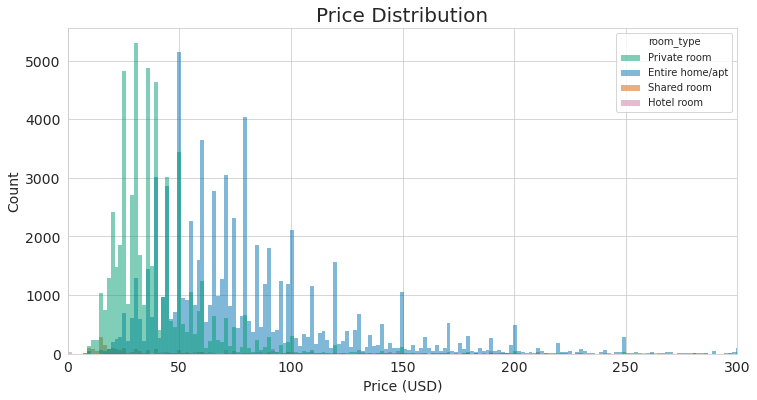

In [65]:
plt.figure(figsize=(12,6))
ax = sns.histplot(data=list3, x="price", hue="room_type", fill=True, palette=["#009E73", "#0072B2", "#D55E00","#CC79A7"])
ax.set_title('Price Distribution', fontsize=20)
ax.set_ylabel('Count',fontsize=14)
ax.set_xlabel('Price (USD)',fontsize=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
plt.xlim(0, 300)
plt.show()

fig = ax.get_figure()
fig.savefig('Data/AirBNB_Berlin/price_distribution.png')

**Figure summary:**

The price distribution shows that the majority of listings are *Private rooms* and *Entire home/apt*.

The *Private room* category has the majority of its listings cheaper than *Entire home/apt* and also has a shorter tail. The room types *Shared room* and *Hotel room* have much fewer counts.

Listings in the *Shared room* category are cheaper than *Private rooms*. *Hotel room* counts are almost indistinguishible.

#### B. What is the room type breakdown? 

In [66]:
#generate the input data for the figure. The fig will use automatic raw data to percent conversion.
names = list3.room_type.value_counts().index
size = list3.room_type.value_counts()
names, size

(Index(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'], dtype='object'),
 Entire home/apt    76285
 Private room       56283
 Shared room         1801
 Hotel room          1665
 Name: room_type, dtype: int64)

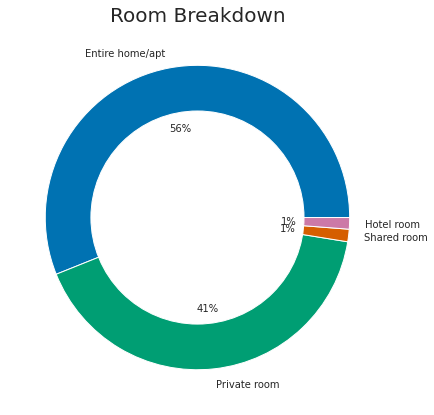

In [67]:
plt.figure(figsize=(7,7))

with sns.color_palette(palette=["#0072B2", "#009E73", "#D55E00","#CC79A7"], n_colors=4):
    white_circle = plt.Circle( (0,0), 0.7, color='white')
    patches, texts, autotexts = plt.pie(size, labels=names, autopct='%.0f%%')
    fig = plt.gcf()
    fig.gca().add_artist(white_circle)
    fig.gca().set_title('Room Breakdown', fontsize=20)
    plt.show()
    
fig.savefig('Data/AirBNB_Berlin/room_types.png')

**Figure summary:**  
The room distribution on AirBnB Berlin is relatively balanced between private rooms (41%) and entire homes/apartments (56%). A much smaller proportion of 1% are shared rooms with other guests, which are hostel style accomodations, and another 1% are listed Hotel rooms. 

#### C. What is the median listing price by room type and district?

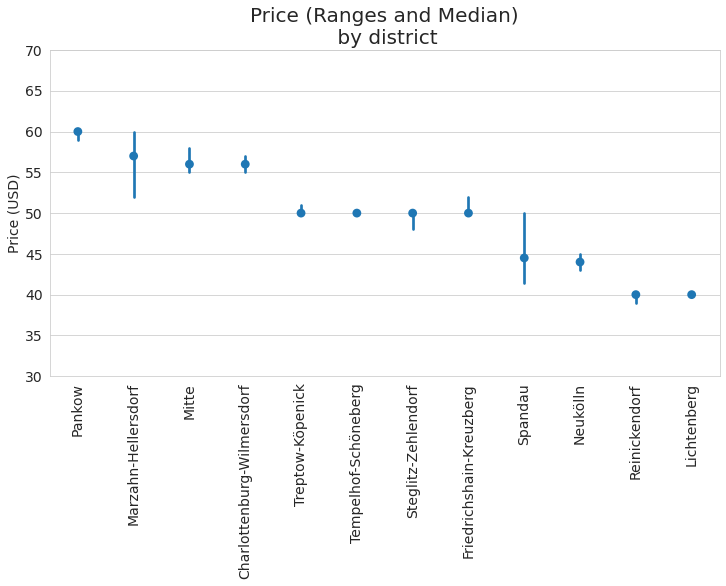

In [68]:
# calculate the ordering of the districts for the graph below
district_price = list3.groupby('district')['price'].median().sort_values(ascending=False)
dist = district_price.index.get_level_values(0)

# actual figure
plt.figure(figsize=(12,6))
ax = sns.pointplot(x="district", y="price", data=list3, order=dist, join=False, estimator=np.median)

#cosmetic stuff
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Price (USD)',fontsize=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_title('Price (Ranges and Median)\n by district', fontsize=20)
ax.set(ylim=(30, 70))
plt.show()

fig = ax.get_figure()
fig.savefig('Data/AirBNB_Berlin/price_range_district.png')

**Figure Summary:**

All room types combined, the top four most expensive districts are Pankow, Marzahn-Hellersdorf, Mitte, and Charlottenburg-Wilmersdorf. These districts are not necessarily all central tourist districts within Berlin, which is counterintuitive. However, the highest prices of Pankow are explained because on its southern end lies the hot neighborhood "Prenzlauer Berg", which is famous for art, night clubs, etc.  The districts Spandau, Neukölln, Reinickendorf, and Lichtenberg are the least expensive. These least expensive districts are on the outer most perimeter of Berlin and have relatively few tourist destinations.   

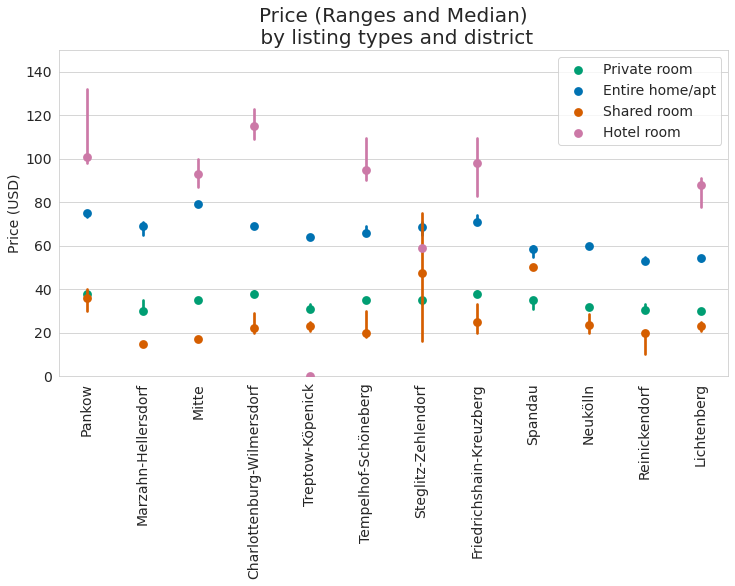

In [70]:
with sns.color_palette("husl", 4):
    plt.figure(figsize=(12,6))
    ax = sns.pointplot(x="district", y="price", hue='room_type', data=list3, estimator=np.median, dodge=False, order=dist, join=False, palette=["#009E73", "#0072B2", "#D55E00","#CC79A7", "#F0E442", "#56B4E9"])
    
    #cosmetic stuff
    ax.legend(loc='upper right', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Price (USD)',fontsize=14)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.set_title('Price (Ranges and Median)\n by listing types and district', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(ylim=(0, 150))
    plt.show()

fig = ax.get_figure()
fig.savefig('Data/AirBNB_Berlin/price_range_type_district.png')

**Figure summary:**  

Generally, listings of the room type category *Hotel* (purple) are most expensive of the four types. The category *Entire homes/apt* (olive) are the most expensive among the non-commercial listings. *Private rooms* (red) are often 25 USD cheaper than Entire homes/apt. *Shared rooms* (green) are least expensive. The Hotel category has in many districts the largest range in prices, which may pull the total median of a district higher.

The median prices of *Private rooms* and *Shared rooms* do not decline in the same pattern as does entire *Home/apartments* but rather, is much more stable among districs. Generally speaking, within a listing category, there is no extreme variablility across districts.

### D. What is the difference in price between super host and non super host listings? 

In [71]:
#look at difference in avrage price between superhost and non superhost listings by district and room type (for entire or private)

#remove shared rooms and hotels
list4 = list3[list3['room_type'] != 'Shared room']
list4 = list4[list4['room_type'] != 'Hotel room']

is_superhost = list4[list4['host_is_superhost'] == 't']
is_superhost_grouped = is_superhost.groupby(['room_type', 'district'])['price'].median().reset_index()

not_superhost = list4[list4['host_is_superhost'] == 'f']
not_superhost_grouped = not_superhost.groupby(['room_type', 'district'])['price'].median().reset_index()

In [72]:
price_by_superhost_status = is_superhost_grouped.rename(columns={'price':"is_superhost_price"})
price_by_superhost_status['not_superhost_price'] = not_superhost_grouped['price']
price_by_superhost_status

,room_type,district,is_superhost_price,not_superhost_price
0,Entire home/apt,Charlottenburg-Wilmersdorf,71.0,69.0
1,Entire home/apt,Friedrichshain-Kreuzberg,82.0,70.0
2,Entire home/apt,Lichtenberg,56.5,54.5
3,Entire home/apt,Marzahn-Hellersdorf,60.0,72.0
4,Entire home/apt,Mitte,90.0,75.0
5,Entire home/apt,Neukölln,70.0,60.0
6,Entire home/apt,Pankow,77.5,72.0
7,Entire home/apt,Reinickendorf,60.0,50.0
8,Entire home/apt,Spandau,110.5,47.5
9,Entire home/apt,Steglitz-Zehlendorf,75.0,65.0


In [73]:
#calculate difference in median price
price_by_superhost_status['diff'] = price_by_superhost_status['is_superhost_price'] - price_by_superhost_status['not_superhost_price']
price_by_superhost_status

,room_type,district,is_superhost_price,not_superhost_price,diff
0,Entire home/apt,Charlottenburg-Wilmersdorf,71.0,69.0,2.0
1,Entire home/apt,Friedrichshain-Kreuzberg,82.0,70.0,12.0
2,Entire home/apt,Lichtenberg,56.5,54.5,2.0
3,Entire home/apt,Marzahn-Hellersdorf,60.0,72.0,-12.0
4,Entire home/apt,Mitte,90.0,75.0,15.0
5,Entire home/apt,Neukölln,70.0,60.0,10.0
6,Entire home/apt,Pankow,77.5,72.0,5.5
7,Entire home/apt,Reinickendorf,60.0,50.0,10.0
8,Entire home/apt,Spandau,110.5,47.5,63.0
9,Entire home/apt,Steglitz-Zehlendorf,75.0,65.0,10.0


In [74]:
#reorder the dataframe to make it acceptable for barh
price_by_superhost_status.set_index('district')

#Use pivot or unstack:
price_2 = price_by_superhost_status.pivot(index='district',columns='room_type',values='diff')
price_2

room_type,Entire home/apt,Private room
district,,
Charlottenburg-Wilmersdorf,2.0,-4.0
Friedrichshain-Kreuzberg,12.0,4.0
Lichtenberg,2.0,-1.0
Marzahn-Hellersdorf,-12.0,1.0
Mitte,15.0,5.0
Neukölln,10.0,4.0
Pankow,5.5,0.0
Reinickendorf,10.0,4.5
Spandau,63.0,-3.5


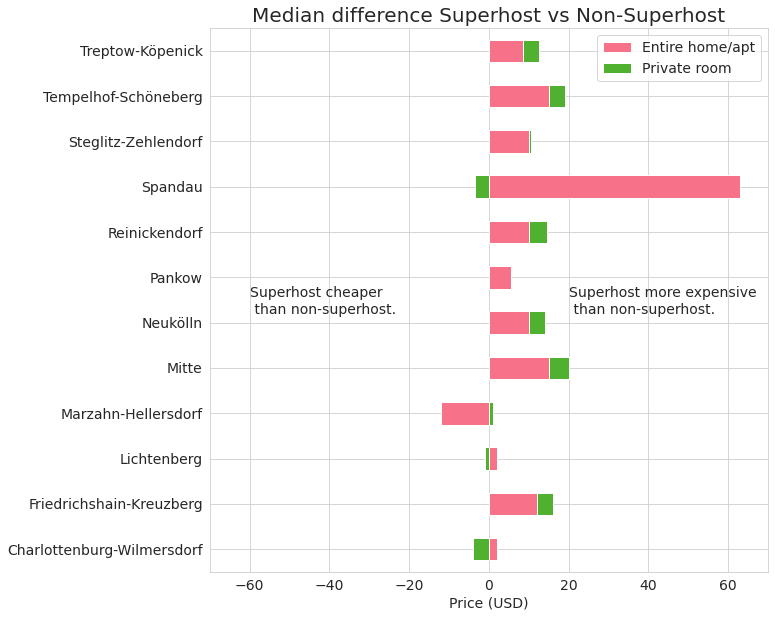

In [75]:
#make grouped bar plot
with sns.color_palette("husl", 3):
    ax = price_2.plot(kind='barh', figsize=(10,10), xlim=(-70,70), stacked=True)
    
    #cosmetic stuff
    ax.set_ylabel('')
    ax.set_xlabel('Price (USD)',fontsize=14)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.legend(loc='upper right', fontsize=14)
    ax.annotate('Superhost cheaper\n than non-superhost.', xy=(2,1), size=14, xytext=(-60, 5.2))
    ax.annotate('Superhost more expensive\n than non-superhost.', xy=(2,1), size=14, xytext=(20, 5.2))
    ax.set_title('Median difference Superhost vs Non-Superhost', fontsize=20)
    plt.show
    
plt.savefig('Data/AirBNB_Berlin/Superhost_price_diff.png')

**Figure summary:**

Colored bars indicate the price difference between superhost and non superhost listings. *Entire homes/apartments* offered by superhosts are more expensive that those offered by non-superhosts in the majority of districts with the exception of Marzahn-Hellersdorf. The largest superhost price premium has to be paid for *Entire home/apt* in Spandau. The price difference is generally larger for *Entire home/apt* than *Private room*, while it is minimized in Pankow, Lichtenberg, and Charlottenburg-Wilmersdorf. 

Where are Superhosts chaper? 
- In Spandau, Lichtenberg, and Charlottenburg-Wilmersdorf, a superhost listing for a *Private room* is, on average, less expensive than that offered by a non-superhost.
- In Marzahn-Hellersdorf, superhost listings for *Entire home/apt* are on average cheaper.

None of these bargain-Superhost districts are located near Berlin's major tourist destinations in Mitte. This means it is probably a valid choice to pick a non-Superhost listing if a cheaper, central location is desired. Counterintuitively, superhosts do not charge a premium everywhere in Berlin. More remote districts are acceptable, then there may be savings possible with superhosts in few, select districts.

## 4. Model  
### E. Which website options influence the price?

In a user mindset -- which factor or option is going to be most influential on the price of listings that are displayed on the website?

### Features to evaluate:
 1. minimum nights 
 2. accommodates
 3. room_type 
 4. beds
 5. bedrooms
 6. month
 7. day_of_week
 8. host is superhost
 9. instant bookable
 10. property type
 12. district (from wiki)
 13. has washer
 14. has dryer
 15. has Wifi
 16. has elevator 
 17. bathrooms

In [76]:
#get the first 20 listing_ids
cal3.listing_id.value_counts()[:5]

39942268    349
30946705    342
41785569    336
39966304    329
35242748    327
Name: listing_id, dtype: int64

In [77]:
#confirm adjusted_price of each listing varies
cal3[cal3['listing_id'] == 35242748]['adjusted_price'].value_counts()

80.0     14
83.0      9
87.0      9
76.0      8
84.0      8
         ..
132.0     1
139.0     1
111.0     1
124.0     1
127.0     1
Name: adjusted_price, Length: 116, dtype: int64

In [78]:
cal3[cal3['listing_id'] == 39966304]['adjusted_price'].value_counts()

87.0     11
82.0      8
89.0      8
99.0      7
88.0      7
         ..
134.0     1
159.0     1
148.0     1
117.0     1
66.0      1
Name: adjusted_price, Length: 125, dtype: int64

### The separate amenities we want to check do not have their own features. They are aggregated in the 'Amenities' feature.

In [79]:
list_cal2.amenities.value_counts()

["Hangers", "Smoke alarm", "Kitchen", "Hot water", "Laptop-friendly workspace", "Building staff", "Heating", "Long term stays allowed", "Essentials", "Paid parking off premises", "Crib", "Luggage dropoff allowed", "Hair dryer", "Wifi", "TV"]                                                                                                                                                                                                                                                                                                                                         9464
["Kitchen", "Free parking on premises", "Heating", "Private entrance", "Essentials", "First aid kit", "Fire extinguisher"]                                                                                                                                                                                                                                                                                                               

In [80]:
list_cal2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1198065 entries, 0 to 135997
Data columns (total 84 columns):
 #   Column                                        Non-Null Count    Dtype         
---  ------                                        --------------    -----         
 0   id                                            1198065 non-null  int64         
 1   listing_url                                   1198065 non-null  object        
 2   scrape_id                                     1198065 non-null  int64         
 3   last_scraped                                  1198065 non-null  object        
 4   name                                          1197948 non-null  object        
 5   description                                   1186567 non-null  object        
 6   neighborhood_overview                         846359 non-null   object        
 7   picture_url                                   1198065 non-null  object        
 8   host_id                                    

In [81]:
#make some amenities columns with true/false as flag
list_cal2['has_wifi'] =     np.where(list_cal2['amenities'].str.contains('Wifi', flags=re.IGNORECASE,regex=False),'true', 'false')
list_cal2['has_elevator'] = np.where(list_cal2['amenities'].str.contains('Elevator', flags=re.IGNORECASE,regex=False),'true', 'false')
list_cal2['has_washer'] =   np.where(list_cal2['amenities'].str.contains('Washer', flags=re.IGNORECASE,regex=False),'true', 'false')
list_cal2['has_dryer'] =    np.where(list_cal2['amenities'].str.contains('Dryer', flags=re.IGNORECASE,regex=False),'true', 'false')
list_cal2['has_ac'] =       np.where(list_cal2['amenities'].str.contains('Air conditioning', flags=re.IGNORECASE,regex=False),'true', 'false')

C:\Users\ChristianV700\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ChristianV700\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ChristianV700\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [82]:
#trim dataset to explore missing info in only certain columns (removed 'neighbourhood_cleansed'- too many one-hot-categories)
features = list_cal2[['minimum_nights', 'accommodates', 'room_type', 'beds', 'bedrooms', 'month', 'day_of_week', 'host_is_superhost', 'instant_bookable', 'property_type',
                       'district', 'has_washer', 'has_dryer', 'has_wifi', 'has_elevator', 'bathrooms_numerical']]

In [83]:
#explore the selected data to see about remaining missing information that wasnt taken care of in listings section above
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1198065 entries, 0 to 135997
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   minimum_nights       1198065 non-null  int64  
 1   accommodates         1198065 non-null  int64  
 2   room_type            1198065 non-null  object 
 3   beds                 1198065 non-null  float64
 4   bedrooms             1198065 non-null  float64
 5   month                1198065 non-null  float64
 6   day_of_week          1198065 non-null  object 
 7   host_is_superhost    1198065 non-null  object 
 8   instant_bookable     1198065 non-null  object 
 9   property_type        1198065 non-null  object 
 10  district             1198065 non-null  object 
 11  has_washer           1198065 non-null  object 
 12  has_dryer            1198065 non-null  object 
 13  has_wifi             1198065 non-null  object 
 14  has_elevator         1198065 non-null  object 
 15 

In [84]:
label = list_cal2['adjusted_price']
label.shape

(1198065,)

In [85]:
#one-hot-encode categorical data (removed'neighbourhood_cleansed')
features_final = pd.get_dummies(features, columns=['room_type', 'day_of_week', 'host_is_superhost', 'instant_bookable', 'property_type', 'district', 'has_washer', 'has_dryer', 'has_wifi', 'has_elevator'])
features_final.columns

Index(['minimum_nights', 'accommodates', 'beds', 'bedrooms', 'month',
       'bathrooms_numerical', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'day_of_week_Friday', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'host_is_superhost_f',
       'host_is_superhost_t', 'instant_bookable_f', 'instant_bookable_t',
       'property_type_Boat', 'property_type_Camper/RV',
       'property_type_Entire apartment', 'property_type_Entire bungalow',
       'property_type_Entire cabin', 'property_type_Entire condominium',
       'property_type_Entire cottage', 'property_type_Entire guest suite',
       'property_type_Entire guesthouse', 'property_type_Entire house',
       'property_type_Entire loft', 'property_type_Entire place',
       'property_type_Entire serviced apartment',
       'property_type_Entire townhouse', 'p

In [86]:
# this sklearn function shuffles by default and then splits
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    label, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [87]:
# samples in train vs test
X_train.shape[0], X_test.shape[0]

(838645, 359420)

### Use Regressors to Predict Prices
Methods
 1. Random Forest
 2. Linear Regression
 3. Gradient Boosting

### Model 1: Random Forest Regressor

In [88]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#absolute default params
clf = RandomForestRegressor(random_state=42)

# Make predictions using the unoptimized and model
model = clf.fit(X_train, y_train)
randomforest_pred = model.predict(X_test)

In [89]:
print("Unoptimized model\n------")
print("R2 on testing data: {:.4f}".format(r2_score(y_test, randomforest_pred)))

Unoptimized model
------
R2 on testing data: 0.8820


It seems that the default options are yielding better results. This model and dataset fed into the model can be worked on to improve prediction accuracy but for now, this is a good starting point. 

In [90]:
#obtain variable importances
importances = model.feature_importances_
importances

array([2.79029863e-02, 1.21990183e-01, 1.52542104e-02, 1.04388185e-02,
       3.36726004e-01, 4.91401582e-02, 1.17607937e-03, 1.81258490e-02,
       1.67481032e-03, 2.49845835e-03, 4.65938375e-03, 6.77132138e-03,
       4.51325065e-03, 2.85503822e-03, 4.24879921e-03, 9.71489162e-03,
       2.22886288e-03, 8.89961173e-03, 8.77587842e-03, 3.34756478e-03,
       3.36040463e-03, 6.00046022e-08, 3.07706931e-05, 2.16007292e-02,
       6.21963370e-05, 2.89241333e-05, 1.02196256e-02, 2.76194124e-05,
       2.16530768e-05, 8.46534481e-05, 1.28473869e-04, 9.21623864e-04,
       6.05835312e-06, 3.77222000e-03, 4.57335539e-05, 1.72207228e-05,
       4.95150757e-03, 4.11778176e-06, 2.59257728e-02, 1.98388977e-08,
       3.68201635e-06, 5.35900760e-08, 3.76217007e-08, 2.60289534e-07,
       3.19834619e-05, 1.72901274e-05, 5.23079120e-06, 3.31949903e-04,
       4.90107992e-04, 6.47276399e-06, 5.40200955e-05, 4.72081903e-05,
       8.97406086e-07, 3.21676151e-06, 8.51574913e-05, 6.32542935e-06,
      

In [91]:
# create new df with imprance values
imp = pd.DataFrame(importances, columns=[ 'importance'])

# add feature columns to a new column named 'features'
imp['feature'] = features_final.columns

# elevate 'features' to index
pd.options.display.float_format = '{:.2f}'.format
imp = imp.set_index('feature')

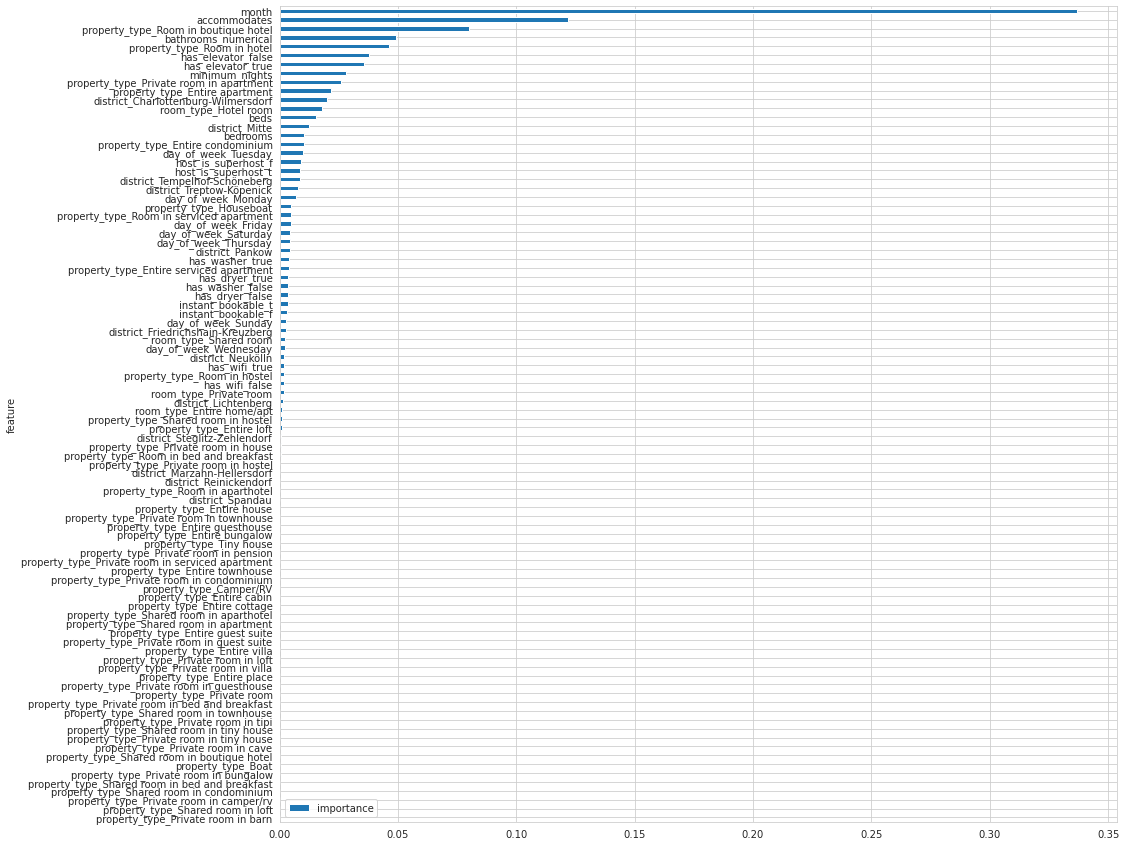

In [92]:
#plot variable importance
imp.sort_values('importance', ascending=True).plot(kind='barh', figsize=(15,15))
plt.savefig('Data/AirBNB_Berlin/importance_plot.png')

**Figure Summary:**

The Random Forest Regressor yielded the most important options driving price variability with a satisfactory model score of R2 = 0.88. 

They factors are are in descending importance:

1. Month
2. Number of Persons ('accommodates')
3. Boutique Hotel
4. Number of Bathrooms
5. Hotel Room
6. Elevator (presence and absence are equally important)
7. Minimum Nights
8. Private Room in Apartment
9. Entire Apartment
10. District "Charlottenburg-Wilmersdorf"
11. Hotel
12. Beds
14. District "Mitte"

The month is twice as important than the numer of people accommodated. As an investigation on the influence of the month I want to visualize the prices per listing type and month.

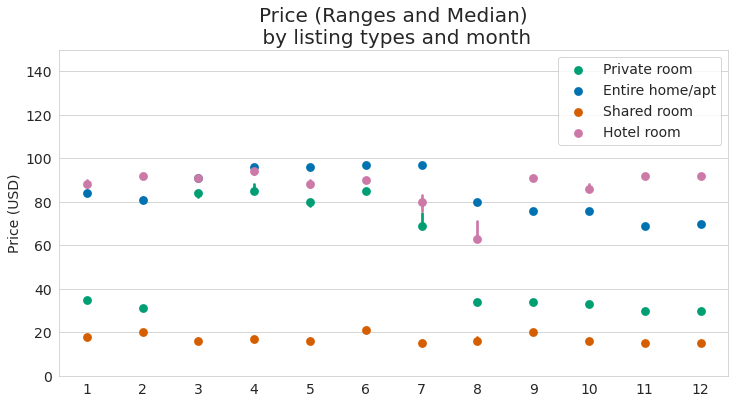

In [93]:
month_order = list(range(1,13))

with sns.color_palette("husl", 4):
    plt.figure(figsize=(12,6))
    ax = sns.pointplot(x="month", y="price", hue='room_type', data=list_cal2, estimator=np.median, dodge=False, order=month_order, join=False, palette=["#009E73", "#0072B2", "#D55E00","#CC79A7", "#F0E442", "#56B4E9"])
    
    #cosmetic stuff
    ax.legend(loc='upper right', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Price (USD)',fontsize=14)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.set_title('Price (Ranges and Median)\n by listing types and month', fontsize=20)
    ax.set(ylim=(0, 150))
    plt.show()

fig = ax.get_figure()
fig.savefig('Data/AirBNB_Berlin/price_range_type_month.png')

**Figure Summary:**

*Private room* prices almost double in Spring and Summer (March to July) and are almost on par with the more expensive room types. *Entire home/apt* listings also increas during this month, but much less pronounced. *Hotel rooms* have a drop in prices in August, which may or may not be correlated that the data was scraped in August and short-term booking was discounted. *Shared rooms* show very little variance across the year.

### Model 2: Linear Regression

In [94]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression().fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
r2_score(y_test,y_pred)

0.20181638850109918

Linear regression has very poor prediction power.

### Model 3: Gradient Boosting

In [95]:
from sklearn.ensemble import GradientBoostingRegressor

clf = GradientBoostingRegressor(random_state=42)
parameters = {'max_features':range(10,60,10)}

#make scorer
scorer = make_scorer(mean_squared_error)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

gb_mod= clf.fit(X_train, y_train)
gb_pred = gb_mod.predict(X_test)
gb_best_pred = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("R2 on testing data: {:.4f}".format(r2_score(y_test, gb_pred)))
print("\nOptimized Model\n------")
print("Final R2 on the testing data: {:.4f}".format(r2_score(y_test, gb_best_pred)))

Unoptimized model
------
R2 on testing data: 0.4732

Optimized Model
------
Final R2 on the testing data: 0.3260


**Model Summary:**

The Random Forest Regressor offered the best R2 (0.8820)!